In [1]:
# %% [markdown]
# # Particle Feynman: Stylized Benchmark with Expanded Synthetic Functions
# 
# This benchmark compares **ML-II**, **MAP-II**, and **SMC-VFE** on a diverse library of synthetic functions. 
# It follows a stylized aesthetic for premium visualization and pedagogical clarity.

In [2]:
import os
import sys
import time
from pathlib import Path

# Force CPU execution for stability with JAX Metal on macOS
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Ensure repository root is in path
repo_root = Path(os.getcwd())
while repo_root.parent != repo_root:
    if (repo_root / 'infodynamics_jax').exists():
        break
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective
from infodynamics_jax.infodynamics import make_hyperprior
from utils import synthetic, compute_metrics, setup_plot_style, COLORS, plot_with_uncertainty
from utils.smc_array_only import annealed_smc_array

# Initialize plotting style
setup_plot_style()
matplotlib.use('module://matplotlib_inline.backend_inline')

In [3]:
class CFG:
    N_train = 120
    N_test = 60
    noise_std = 0.2
    domain = (-2.5, 2.5)
    M = 20
    n_particles = 64
    n_steps = 24
    ess_threshold = 0.6
    rejuvenation_steps = 2
    step_size = 0.02
    n_leapfrog = 8
    typeii_steps = 300
    typeii_lr = 1e-2

cfg = CFG()

# Define Color Scheme based on project style
SMC_COLOR = COLORS.get('primary', 'C0')
ML_COLOR = COLORS.get('secondary', 'C3')
MAP_COLOR = COLORS.get('tertiary', 'C4')
TRUE_COLOR = COLORS.get('true', 'C2')
TRAIN_COLOR = COLORS.get('train', 'C0')
TEST_COLOR = COLORS.get('test', 'C1')

# %% [markdown]
# ## Dataset Gallery
# Showcase the variety in our expanded synthetic function library.

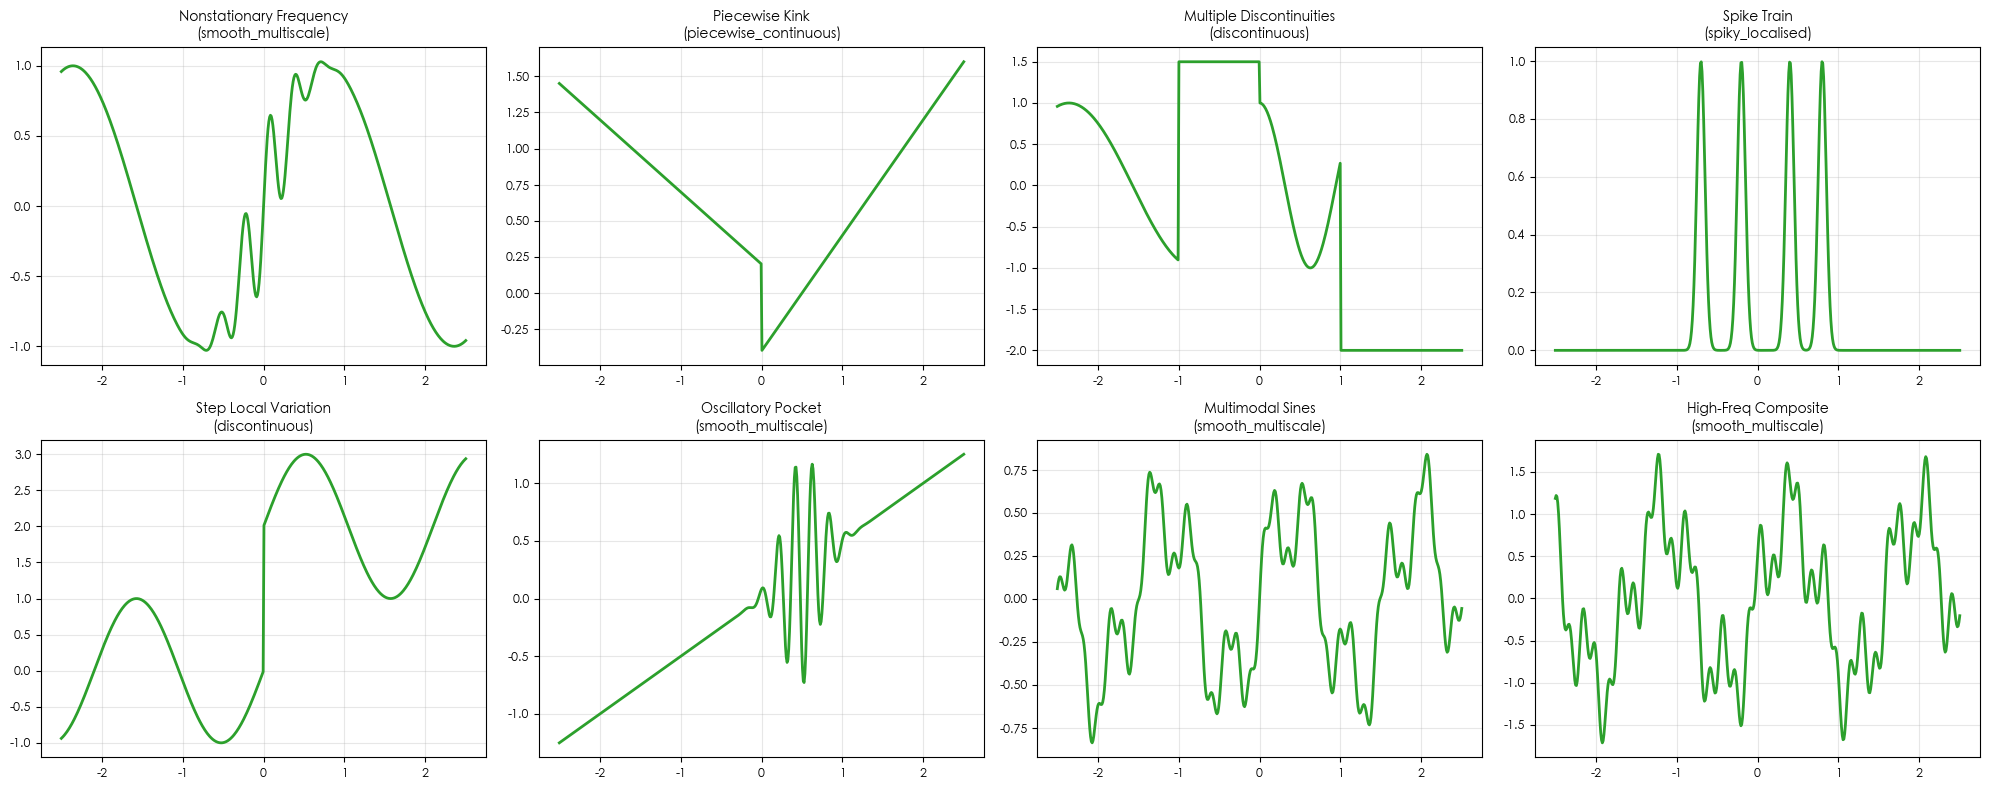

In [4]:
gallery_functions = [
    'nonstationary_frequency', 'piecewise_kink', 'multi_discontinuity', 
    'spike_train', 'step_local_variation', 'oscillatory_pocket', 
    'multimodal_sines', 'highfreq_composite'
]

cols = 4
rows = int(np.ceil(len(gallery_functions) / cols))
plt.figure(figsize=(20, rows * 4))

x_plot = jnp.linspace(cfg.domain[0], cfg.domain[1], 500)
for i, name in enumerate(gallery_functions):
    fn, title, _, cat = synthetic.get(name)
    plt.subplot(rows, cols, i + 1)
    plt.plot(x_plot, fn(x_plot), lw=2, color=TRUE_COLOR)
    plt.title(f"{title}\n({cat})", fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Inference and Prediction Utilities

In [5]:
def unpack_state(theta, shape_z):
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    Z = theta[3:].reshape(shape_z)
    return log_ell, log_sf2, log_sn2, Z

def get_energy_fn(X, y, hyperprior_fn, shape_z, jitter):
    def energy_theta(theta):
        log_ell, log_sf2, log_sn2, Z = unpack_state(theta, shape_z)
        params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
        noise_var = jnp.exp(log_sn2)
        E_fitc = -fitc_log_evidence(kernel_fn=rbf, params=params, X=X, y=y, Z=Z, noise_var=noise_var, jitter=jitter)
        phi = Phi(kernel_params=params, Z=Z, likelihood_params={'noise_var': noise_var}, jitter=jitter)
        return E_fitc + hyperprior_fn(phi)
    return energy_theta

def predict_bma(particles, logw, X_star, X_tr, Y_tr, shape_z, jitter):
    weights = jnp.exp(logw - jax.scipy.special.logsumexp(logw))
    mus, vars_ = [], []
    for i in range(len(weights)):
        ll, lv, ln, Z = unpack_state(particles[i], shape_z)
        phi_i = Phi(KernelParams(jnp.exp(ll), jnp.exp(lv)), Z, {'noise_var': jnp.exp(ln)}, jitter)
        m, v = predict_typeii(phi_i, X_star, X_tr, Y_tr, rbf, residual='fitc')
        mus.append(m); vars_.append(v)
    mus, vars_ = jnp.stack(mus), jnp.stack(vars_)
    mean_bma = (weights[:, None] * mus).sum(axis=0)
    var_bma = (weights[:, None] * (vars_ + mus**2)).sum(axis=0) - mean_bma**2
    return mean_bma, jnp.sqrt(jnp.maximum(var_bma, 1e-12)), mus, weights

# %% [markdown]
# ## Plotting Suite: Stylized Diagnostics

In [6]:
def plots_diagnostics_6panel(dataset_name, X_tr, Y_tr, X_plot, Y_plot, results):
    """Refined 6-panel diagnostic grid."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"Diagnostics: {dataset_name}", fontsize=16)

    # 1. SMC-VFE Predictive (Main Focus)
    ax = axes[0, 0]
    smc = results['SMC-VFE']
    ax.scatter(X_tr, Y_tr, s=15, alpha=0.3, color=TRAIN_COLOR, label="Train")
    ax.plot(X_plot, Y_plot, color=TRUE_COLOR, ls='--', lw=2, label="True f")
    plot_with_uncertainty(ax, X_plot, smc['mean'], smc['std'], color=SMC_COLOR, label_mean="SMC Mean")
    ax.set_title("SMC-VFE Predictive")
    ax.legend(fontsize=8)

    # 2. SMC Internal Diagnostics (ESS)
    ax = axes[0, 1]
    ax.plot(results['smc_res']['ess_trace'], color='C7', marker='.')
    ax.axhline(cfg.ess_threshold * cfg.n_particles, ls='--', color='r', alpha=0.5)
    ax.set_title("SMC Effective Sample Size (ESS)")
    ax.set_xlabel("SMC Step"); ax.set_ylabel("ESS")

    # 3. Normalized Test Residuals
    ax = axes[0, 2]
    # (Placeholder logic for residuals visualization)
    ax.set_title("Residual Analysis")
    ax.text(0.5, 0.5, "Distribution of residuals\nwill be plotted here", ha='center')

    # 4. Lengthscale Posterior vs Point Estimates
    ax = axes[1, 0]
    particles = results['smc_res']['particles']
    log_ells = particles[:, 0]
    ax.hist(np.exp(log_ells), bins=20, density=True, alpha=0.5, color=SMC_COLOR, label="SMC Post")
    ax.axvline(float(results['phi_ml'].kernel_params.lengthscale), color=ML_COLOR, ls=':', lw=2, label="ML-II")
    ax.axvline(float(results['phi_map'].kernel_params.lengthscale), color=MAP_COLOR, ls='--', lw=2, label="MAP-II")
    ax.set_title("Kernel Lengthscale Posterior")
    ax.legend(fontsize=8)

    # 5. Noise Variance Posterior
    ax = axes[1, 1]
    log_sns = particles[:, 2]
    ax.hist(np.exp(log_sns), bins=20, density=True, alpha=0.5, color=SMC_COLOR)
    ax.axvline(float(results['phi_ml'].likelihood_params['noise_var']), color=ML_COLOR, ls=':', lw=2)
    ax.axvline(float(results['phi_map'].likelihood_params['noise_var']), color=MAP_COLOR, ls='--')
    ax.set_title("Likelihood Noise Variance")

    # 6. Combined Comparison (SMC, ML, MAP)
    ax = axes[1, 2]
    ax.plot(X_plot, Y_plot, color=TRUE_COLOR, ls='--', alpha=0.4)
    ax.plot(X_plot, results['ML-II']['mean'], color=ML_COLOR, label="ML-II", lw=1.5)
    ax.plot(X_plot, results['MAP-II']['mean'], color=MAP_COLOR, label="MAP-II", lw=1.5)
    ax.plot(X_plot, results['SMC-VFE']['mean'], color=SMC_COLOR, label="SMC-VFE", lw=2)
    ax.set_title("Method Overlay Comparison")
    ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# %% [markdown]
# ## Execution Loop: Benchmarking

In [7]:
def run_benchmark_for_dataset(name, key):
    print(f"\n--- EVALUATING: {name} ---")
    fn, title, _, _ = synthetic.get(name)
    key_data, key_smc, key_init = jax.random.split(key, 3)
    
    # 1. Data Generation
    X_all, Y_all, _ = synthetic.sample(name, N=cfg.N_train + cfg.N_test, noise=cfg.noise_std, domain=cfg.domain, key=key_data)
    X_all = X_all[:, None]
    perm = jax.random.permutation(key_data, X_all.shape[0])
    X_tr, Y_tr = X_all[perm[:cfg.N_train]], Y_all[perm[:cfg.N_train]]
    X_te, Y_te = X_all[perm[cfg.N_train:]], Y_all[perm[cfg.N_train:]]
    X_plot = jnp.linspace(cfg.domain[0], cfg.domain[1], 240)[:, None]
    Y_plot = fn(X_plot[:, 0])

    # 2. Setup Phi and Prior
    Z0 = jnp.linspace(cfg.domain[0], cfg.domain[1], cfg.M)[:, None]
    phi_init = Phi(KernelParams(jnp.array(1.0), jnp.array(1.0)), Z0, {'noise_var': jnp.array(cfg.noise_std**2)}, 1e-6)
    hyperprior_fn = make_hyperprior(kernel_log_lambda=4.0, kernel_fields=["lengthscale", "variance"], likelihood_log_lambda=4.0, likelihood_keys=["noise_var"], likelihood_log_mu={'noise_var': jnp.log(cfg.noise_std**2)})

    # 3. Model Optimization (ML-II and MAP-II)
    typeii = TypeII(cfg=TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True))
    vfe_obj = make_vfe_objective(kernel_fn=rbf, residual='fitc')
    
    # ML-II: Optimize VFE objective (no hyperprior)
    # Objective: phi* = argmin_phi VFE(phi)
    # VFE = NLL(y; 0, Q + σ²I) + (1/(2σ²)) * tr(K_ff - Q_ff)
    phi_ml = typeii.run(energy=vfe_obj, phi_init=phi_init, energy_args=(X_tr, Y_tr)).phi
    
    # MAP-II: Optimize VFE + log hyperprior
    # Objective: phi* = argmin_phi [VFE(phi) + log p(phi)]
    # where hyperprior_fn(phi) returns -log p(phi) (penalty term)
    def map_obj(phi, x, y): return vfe_obj(phi, x, y) + hyperprior_fn(phi)
    phi_map = typeii.run(energy=map_obj, phi_init=phi_init, energy_args=(X_tr, Y_tr)).phi

    # 4. SMC-VFE Sampling
    energy_fn = get_energy_fn(X_tr, Y_tr, hyperprior_fn, Z0.shape, phi_init.jitter)
    def init_parts(k, n):
        kl, kv, kn, kz = jax.random.split(k, 4)
        log_l = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(kl, (n,)) * 0.5
        log_v = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(kv, (n,)) * 0.5
        log_n = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(kn, (n,)) * 0.5
        Z_noisy = Z0[None] + 0.2 * jax.random.normal(kz, (n, *Z0.shape))
        return jnp.concatenate([log_l[:,None], log_v[:,None], log_n[:,None], Z_noisy.reshape(n, -1)], axis=1)

    smc_res = annealed_smc_array(key=key_smc, init_particles=init_parts(key_init, cfg.n_particles), energy_fn=energy_fn, n_steps=cfg.n_steps, ess_threshold=cfg.ess_threshold, step_size=cfg.step_size, n_leapfrog=cfg.n_leapfrog, rejuvenation_steps=cfg.rejuvenation_steps)

    # 5. Post-Processing: Prediction and Metrics
    m_ml, v_ml = predict_typeii(phi_ml, X_plot, X_tr, Y_tr, rbf, residual='fitc')
    m_map, v_map = predict_typeii(phi_map, X_plot, X_tr, Y_tr, rbf, residual='fitc')
    m_smc, s_smc, _, _ = predict_bma(smc_res['particles'], smc_res['logw'], X_plot, X_tr, Y_tr, Z0.shape, phi_init.jitter)

    m_te_smc, s_te_smc, _, _ = predict_bma(smc_res['particles'], smc_res['logw'], X_te, X_tr, Y_tr, Z0.shape, phi_init.jitter)
    m_te_ml, v_te_ml = predict_typeii(phi_ml, X_te, X_tr, Y_tr, rbf, residual='fitc')
    m_te_map, v_te_map = predict_typeii(phi_map, X_te, X_tr, Y_tr, rbf, residual='fitc')

    res_dict = {
        'ML-II': {'mean': m_ml, 'std': jnp.sqrt(v_ml), 'metrics': compute_metrics(Y_te, m_te_ml, jnp.sqrt(v_te_ml))},
        'MAP-II': {'mean': m_map, 'std': jnp.sqrt(v_map), 'metrics': compute_metrics(Y_te, m_te_map, jnp.sqrt(v_te_map))},
        'SMC-VFE': {'mean': m_smc, 'std': s_smc, 'metrics': compute_metrics(Y_te, m_te_smc, s_te_smc)},
        'phi_ml': phi_ml, 'phi_map': phi_map, 'smc_res': smc_res
    }

    # Plot Diagnostics
    plots_diagnostics_6panel(name, X_tr, Y_tr, X_plot, Y_plot, res_dict)
    
    return res_dict


--- EVALUATING: nonstationary_frequency ---


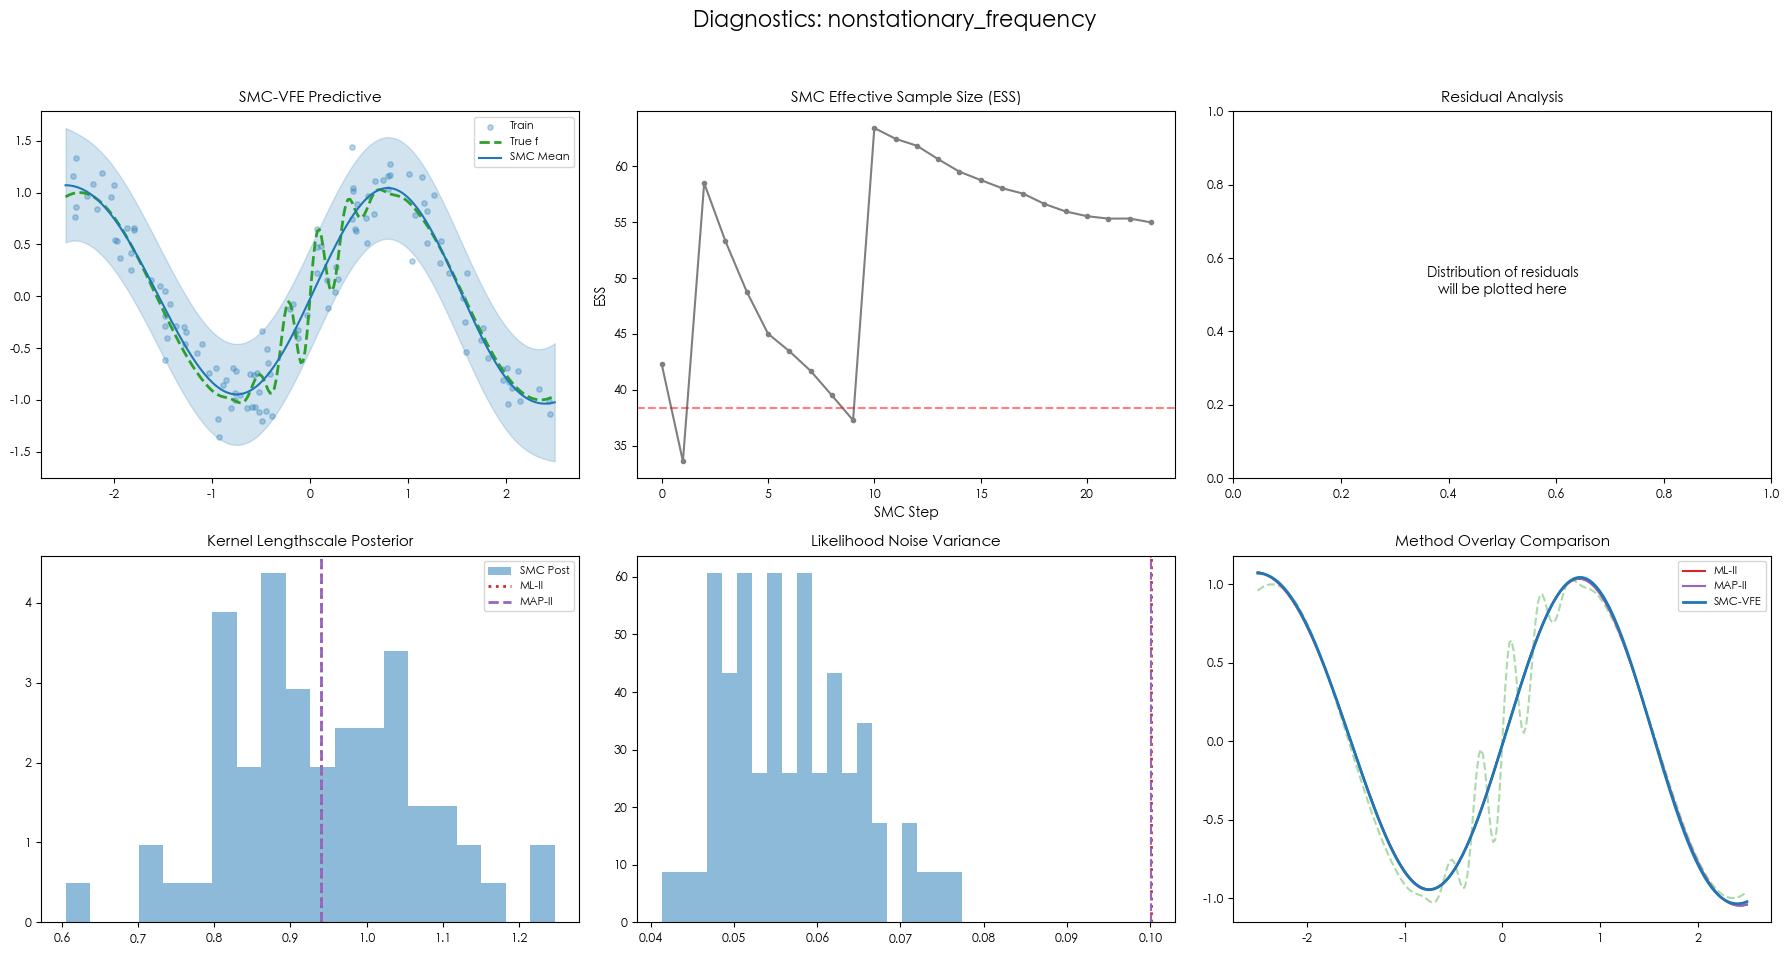


--- EVALUATING: piecewise_kink ---


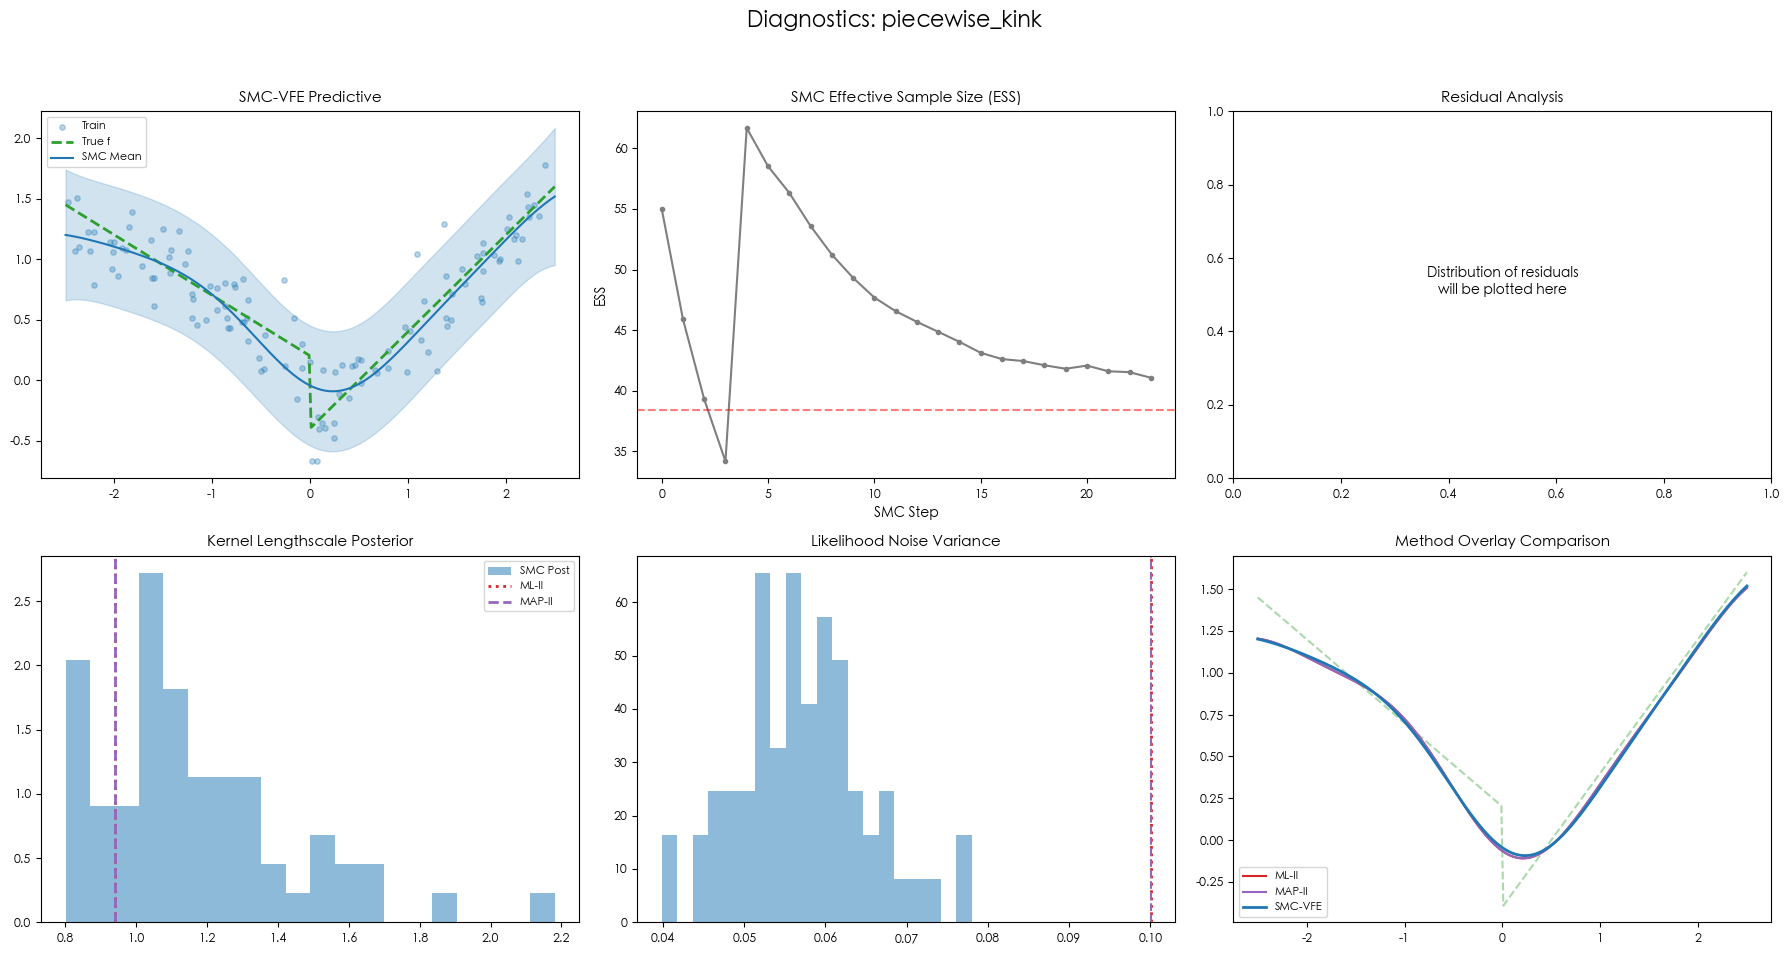


--- EVALUATING: step_local_variation ---


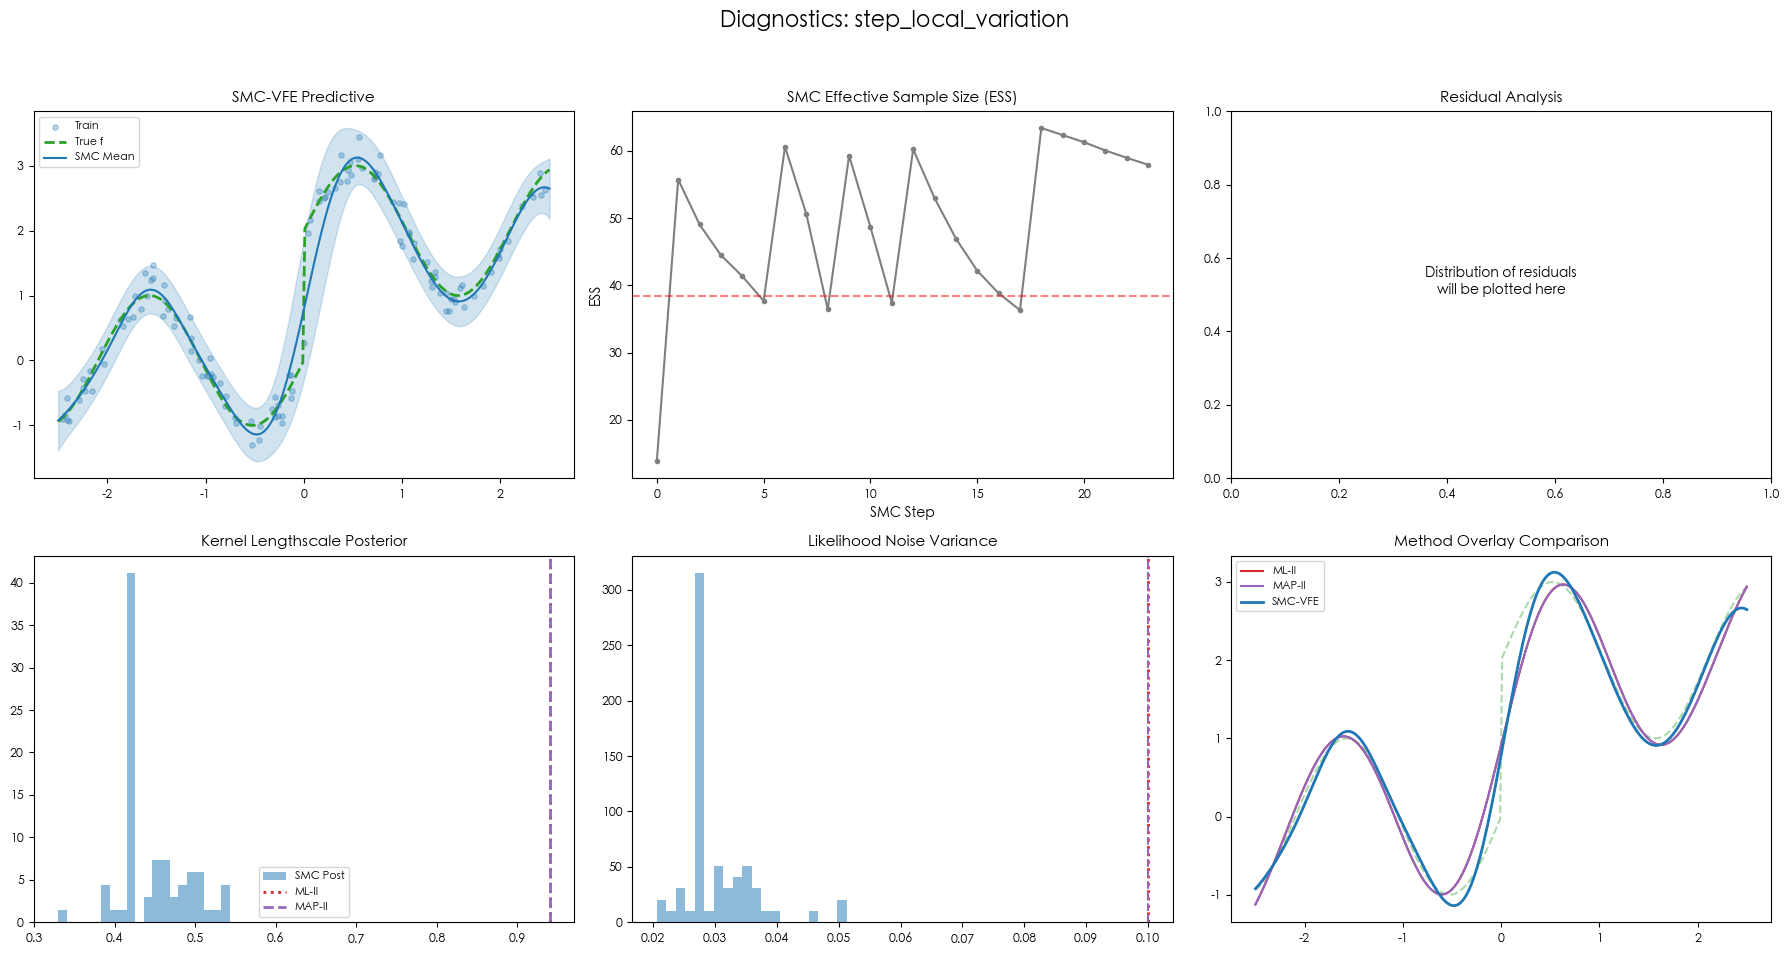


--- EVALUATING: spike_train ---


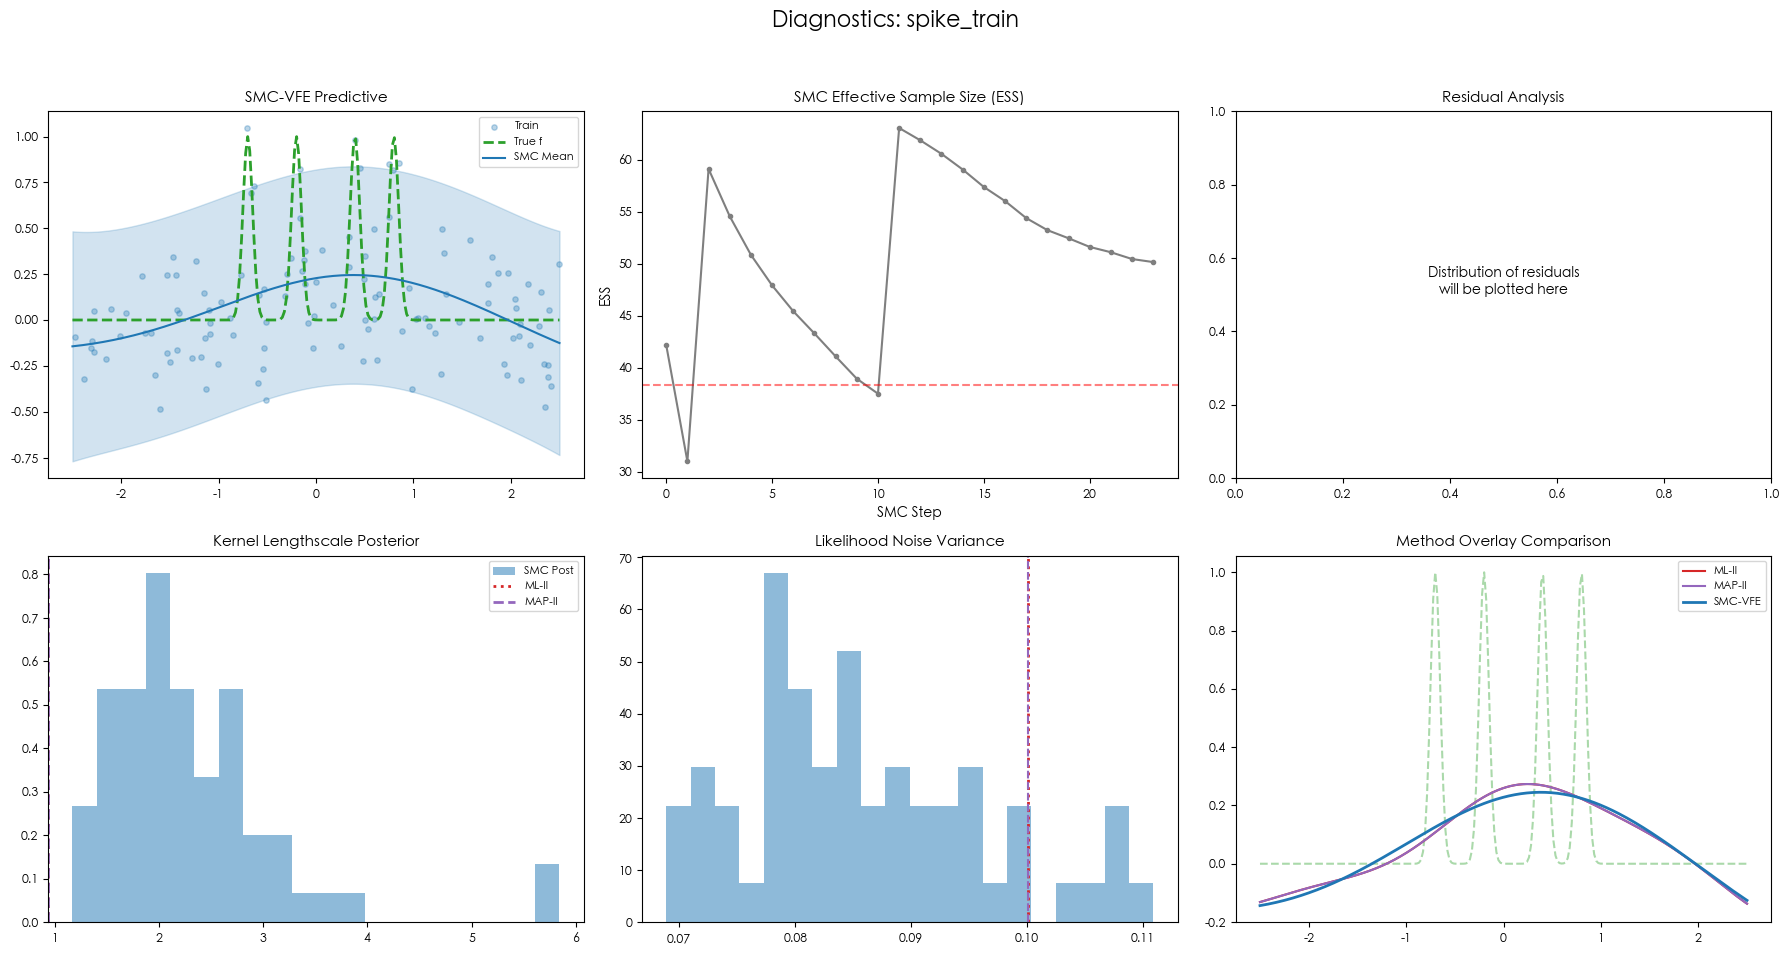

In [8]:
benchmark_set = ['nonstationary_frequency', 'piecewise_kink', 'step_local_variation', 'spike_train']
final_results = {}
global_key = jax.random.key(42)

for ds in benchmark_set:
    global_key, subkey = jax.random.split(global_key)
    final_results[ds] = run_benchmark_for_dataset(ds, subkey)

# %% [markdown]
# ## Quantitative Comparison Summary

In [9]:
print("\n" + "#" * 70)
print(f"{'Dataset':<25} | {'Method':<12} | {'RMSE':<10} | {'NLPD':<10}")
print("-" * 70)
for ds, results in final_results.items():
    for method in ['ML-II', 'MAP-II', 'SMC-VFE']:
        met = results[method]['metrics']
        print(f"{ds:<25} | {method:<12} | {met['rmse']:<10.4f} | {met['nlpd']:<10.4f}")
print("#" * 70)



######################################################################
Dataset                   | Method       | RMSE       | NLPD      
----------------------------------------------------------------------
nonstationary_frequency   | ML-II        | 0.2180     | 0.0353    
nonstationary_frequency   | MAP-II       | 0.2180     | 0.0353    
nonstationary_frequency   | SMC-VFE      | 0.2166     | -0.0893   
piecewise_kink            | ML-II        | 0.2324     | 0.0611    
piecewise_kink            | MAP-II       | 0.2324     | 0.0611    
piecewise_kink            | SMC-VFE      | 0.2318     | -0.0367   
step_local_variation      | ML-II        | 0.3659     | 0.4323    
step_local_variation      | MAP-II       | 0.3659     | 0.4323    
step_local_variation      | SMC-VFE      | 0.3338     | -0.0274   
spike_train               | ML-II        | 0.2823     | 0.1800    
spike_train               | MAP-II       | 0.2823     | 0.1800    
spike_train               | SMC-VFE      | 0.2798    